「TransformerとTorchTextを用いたsequence-to-sequenceモデルの学習」
===============================================================
【原題】Sequence-to-Sequence Modeling with nn.Transformer and TorchText

【元URL】https://pytorch.org/tutorials/beginner/transformer_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年10月13日

【チュトーリアル概要】

本チュートリアルでは、Attention機構を備えたTransformerモジュールを使用したsequence-to-sequenceモデルの実装手法と訓練方法を解説します。

WikiText2から取得した文章において、文章＝単語系列（sequence）を入力し、その次に来るであろう単語を予測するsequence-to-sequenceモデルを構築します。

<br>

---




本ノートブックは、[nn.Transformer](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer)モジュールを使用した、sequence-to-sequenceモデル学習の解説チュートリアルです。

PyTorch 1.2 以降では、論文 [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)を基に実装された、標準的なTransformerのモジュールが用意されています。

<br>

Transformerモデルは、これまでのモデル（日本語訳注：RNN系）と比べてより並列化が容易であると同時に、多くのsequence-to-sequenceのタスクにおいて、より優れた結果が得られることが実証されています。




`nn.Transformer`モジュールは、Attensionメカニズム（最近、
[nn.MultiheadAttention](https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention)として実装された別のモジュール）に完全に依存しています。このAttensionメカニズムにより、入力と出力の間の大域的な依存関係を捉えることができます。

`nn.Transformer`モジュールは、単一でも使用しやすいように、高度にモジュール化されており、簡単に、`nn.Transformer`モジュールをコンポーネント（本チュートリアルの[nn.TransformerEncoder](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder)など）に適用したり、あるいは`nn.Transformer`モジュールを使って、コンポーネントを作成したりすることができます。

<br>

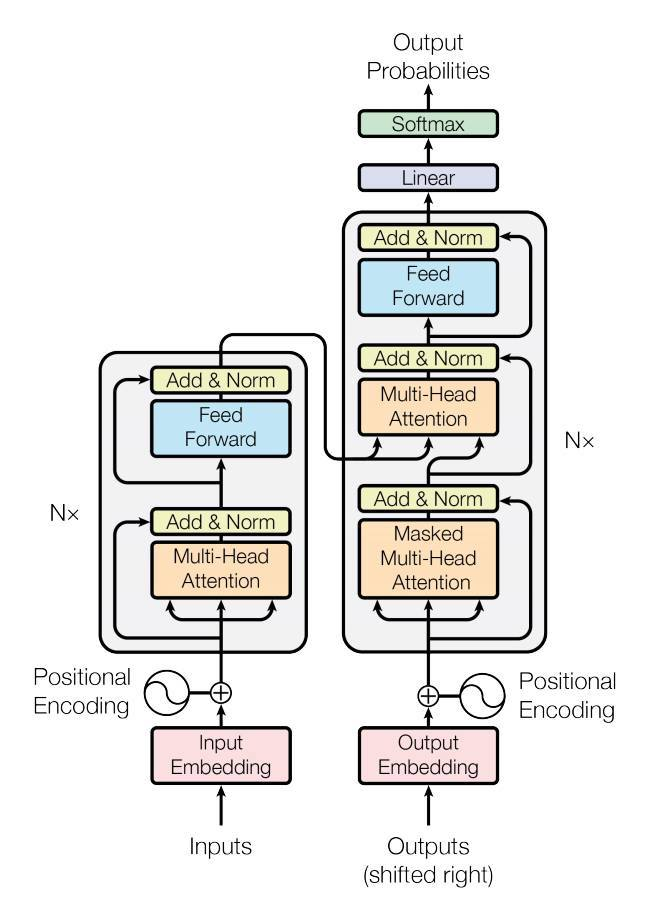

モデルの定義
----------------


本チュートリアルでは、言語モデルタスクで`NN.TransformerEncoder`モデルを訓練します。

ここでの言語モデルタスク（language modeling task）とは、特定の単語（または単語のシーケンス）が、与えられた単語シーケンスの後に続けて登場する確率を当てるタスクです。




単語（トークン）のシーケンスは、最初にモデルの埋め込み層に渡され、その後、単語の順序の情報を得るための位置エンコーディング層（詳細は次の段落）へと渡されます。


`nn.TransformerEncoder`は、複数の[NN.TransformerEncoderLayer](https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLaye)の層で構成されています。

言語モデルタスクでは、入力シーケンスと共に、アテンション・マスクが必要です。

なぜなら、`NN.TransformerEncoder`のSelf-Attention層では、シーケンス内でより前方に登場するトークンのみに着目することが許されているためです。

※日本語訳注：RNNでも単語は前から順番に入力され、後ろの単語は通常、考慮できないので、その状態を再現しています（後方からのシーケンスを利用する場合もありますが）。

普通の日常会話でも、会話最中に、会話の先の内容を事前に聞くことはできない点と同じ状況です。



そこで、言語モデルタスクでは、後方の位置にある単語（トークン）は未知のトークンとして扱うため、マスクする必要があります。

正解の単語を求めるために、`NN.TransformerEncoder`モデルの出力は、最終的に全結合層に送られ、その後にlog-Softmax関数で処理されます。

In [1]:
# 日本語訳注：追加
%matplotlib inline
!pip3 install torchtext==0.4.0

     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != src.size(0):
            device = src.device
            mask = self._generate_square_subsequent_mask(src.size(0)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

`PositionalEncoding` モジュールは、シーケンス内のトークンの相対的な位置、もしくは絶対的な位置に関する情報をモデルに与えます。


位置エンコーディング層（PositionalEncoding Layer）は、埋め込み層と同じ次元であり、位置エンコーディングの出力と、埋め込み層の出力は足し算することができます。

ここでは，異なる周波数のサイン波関数とコサイン波関数を使用し、位置エンコーディングを行っています。

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

データの読み込みとバッチ処理
-------------------

学習には`torchtext`のWikitext-2データセットを使用します。

vocabオブジェクトは訓練データセットを元に構築され、トークン（単語）をテンソル形式の数値に変換するために使用されます。

`batchify()`  関数は、シーケンス形式のデータ（トークンが左から右に一つずつ並んだ形）を、列が並んだ形式に変換します。変換する際には、データを``batch_size`` 変数のサイズで分割し、最後に余ったトークンは無視されます。

例えば、アルファベットをシーケンス (長さ26) とし、バッチサイズを 4 とすると、アルファベットを長さ 6 の 4 つのシーケンスに分割したのが以下の例です。

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}



各列（=バッチ）は、モデル内では独立したものとして扱われます。そのため、例えば ``F`` と ``G`` の依存関係を学習することはできません。

（日本語訳注：FとGは連続したアルファベットという依存関係がありますが、それはこの学習では考慮できないことになります）


しかしながら、各バッチを独立したものとして扱うことで、より効率的なバッチ処理が可能になります。

In [4]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # データセットをbszサイズに分割した際のバッチ数を求める
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 64.5MB/s]

downloading wikitext-2-v1.zip
extracting


In [5]:
# 日本語訳注：追記（GPUの確認と訓練データの確認）

print("GPU環境：", device)  # GPU環境であれば、cuda と表示されます
print("訓練データのサンプル：", train_txt.examples[0].text[:100])

GPU環境： cuda
訓練データのサンプル： ['<eos>', '=', 'valkyria', 'chronicles', 'iii', '=', '<eos>', '<eos>', 'senjō', 'no', 'valkyria', '3', '<unk>', 'chronicles', '(', 'japanese', '戦場のヴァルキュリア3', ',', 'lit', '.', 'valkyria', 'of', 'the', 'battlefield', '3', ')', ',', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', ',', 'is', 'a', 'tactical', 'role', '@-@', 'playing', 'video', 'game', 'developed', 'by', 'sega', 'and', 'media', '.', 'vision', 'for', 'the', 'playstation', 'portable', '.', 'released', 'in', 'january', '2011', 'in', 'japan', ',', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'valkyria', 'series', '.', '<unk>', 'the', 'same', 'fusion', 'of', 'tactical', 'and', 'real', '@-@', 'time', 'gameplay', 'as', 'its', 'predecessors', ',', 'the', 'story', 'runs', 'parallel', 'to', 'the', 'first', 'game', 'and', 'follows', 'the']


<br>

**入力シーケンスとTargetシーケンスを生成するための関数**

``get_batch()``関数は，Transformerモデルの入力シーケンスと、Targetシーケンスを生成します。

この関数はソースデータを変数``bptt``の長さのチャンクデータに細分化します。

 言語モデルのタスクでは、入力シーケンスに後続する単語がTargetとして必要となります。
 
 例えば以下の図で、``bptt`` の値が 2 の場合、``i`` = 0 に後続する2 つの要素を取得します。

<br>

日本語訳注：bpttより2つの要素をinputに使用。

下の図では、モデルへの入力（とあるタイミングで来た単語）とモデルが予測して欲しい出力（次のタイミングで来るべき単語）を表示しています。



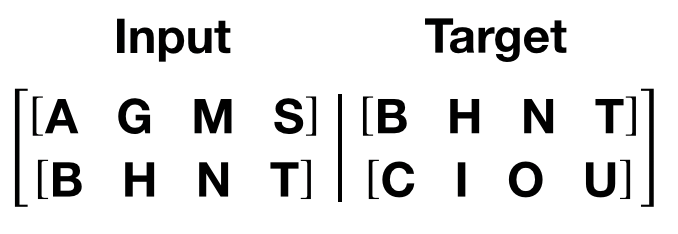

``get_batch()``関数の返り値``data``変数の 0 次元目 がチャンクの長さで、これはトランスフォーマーモデルの 次元``S``と一致していることに注意してください。

また、``data``変数の 1 次元目 はバッチサイズを示す次元数 ``N`` となっています。

In [6]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

インスタンスの初期化
--------------------

モデルは、以下のハイパーパラメータを使用して設定されます。vocabのサイズは、vocabオブジェクトの長さと同じです。

In [7]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

モデルの実行
-------------




[CrossEntropyLoss](https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)は損失値を計算するために適用され、[SGD](https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD)はオプティマイザとして使われる確率的勾配降下法です。

初期の学習率は5.0に設定しています。


エポック単位で学習率を調整するために[StepLR](https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR)__を使用します。

訓練中は、勾配爆発を防ぐために、[nn.utils.clip_grad_norm](https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_) 関数を用いて、全ての勾配をまとめた後、大きさをスケーリングしています。

（日本語訳注：ここでのスケーリングとは、clip_grad_normで勾配が大きすぎる値は設定した上限値に変更するスケーリング操作を示します）

In [8]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # 学習率
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # 訓練モードに
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # 検証モードに
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

エポックを繰り返します。

その最中に、検証データの損失がそれまでの実行のなかで最も良い（低い）場合はモデルを保存します。

そして、各エポックの後に学習率を調整し小さくします。

In [9]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 2981 batches | lr 5.00 | ms/batch 18.01 | loss  7.99 | ppl  2946.49
| epoch   1 |   400/ 2981 batches | lr 5.00 | ms/batch 16.62 | loss  6.79 | ppl   890.76
| epoch   1 |   600/ 2981 batches | lr 5.00 | ms/batch 16.79 | loss  6.37 | ppl   582.28
| epoch   1 |   800/ 2981 batches | lr 5.00 | ms/batch 16.73 | loss  6.24 | ppl   511.11
| epoch   1 |  1000/ 2981 batches | lr 5.00 | ms/batch 16.73 | loss  6.12 | ppl   452.94
| epoch   1 |  1200/ 2981 batches | lr 5.00 | ms/batch 16.74 | loss  6.09 | ppl   442.13
| epoch   1 |  1400/ 2981 batches | lr 5.00 | ms/batch 16.81 | loss  6.05 | ppl   425.44
| epoch   1 |  1600/ 2981 batches | lr 5.00 | ms/batch 16.81 | loss  6.04 | ppl   421.63
| epoch   1 |  1800/ 2981 batches | lr 5.00 | ms/batch 16.86 | loss  5.95 | ppl   384.24
| epoch   1 |  2000/ 2981 batches | lr 5.00 | ms/batch 16.83 | loss  5.96 | ppl   389.04
| epoch   1 |  2200/ 2981 batches | lr 5.00 | ms/batch 16.87 | loss  5.85 | ppl   348.46
| epoch   1 |  2400/ 

テストデータセットでモデルを評価する
-------------------------------------

結果を確認するために、ベストモデルでテスト用データセットを評価してみます。



In [10]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.45 | test ppl   232.03
